## Overview

The goal of this notebook is to illustrate and compare different LCP solutions to Ben Moll's [vanilla example](http://www.princeton.edu/~moll/HACTproject/option_simple.pdf).

Here is a summary of the methods tried and relevant information.

| Method | Successful? | Time | 
|--------|----------|--------|
| `PATHSolver.jl` | Yes | 0.4 seconds (`1e-4` tolerance, second run) |
| `Complementarity.jl` | No | N/A (Note: Calls to `PATHSolver` for solution) | 
| `NLsolve.jl` | Yes | 0.2 seconds (`ftol = 1e-4`, second run) | 
| `VariationalInequality.jl` | ~ | ~

#### Setup

Let's pull parameters from the [MATLAB code](https://github.com/econtoolkit/continuous_time_methods/blob/master/matlab/tests/simple_optimal_stopping_diffusion_test.m).

In [1]:
using Parameters, LinearAlgebra

StoppingProblem = @with_kw (μ_bar = -0.01, 
                            σ_bar = 0.01, 
                            S_bar = 10.0, 
                            γ = 0.5, # u(x) = x^γ
                            ρ = 0.05, # discount rate
                            x_min = 0.01,
                            x_max = 1.0,
                            M = 300) # num of grid points 

#3 (generic function with 2 methods)

Let's also copy the discretization method from [PTW](https://github.com/jlperla/PerlaTonettiWaugh.jl/commits/master/src/utils/diffusionoperators.jl). This is for a reflecting barrier at each boundary.

In [2]:
# Diffusion operators with regular grids
function diffusionoperators(x::AbstractRange; ξ = 0.0) # ξ = 0.0 corresponds to the unrescaled case from PTW
    Δ = step(x)
    P = length(x)

    dl_1 = zeros(P-1)
    d_1 = -ones(P)
    du_1 = ones(P-1)
    d_1[end] = d_1[end] + du_1[end] * (1-ξ*Δ)
    L_1_plus = Tridiagonal(dl_1, d_1, du_1)/Δ

    dl_m1 = -ones(P-1)
    d_m1 = ones(P)
    du_m1 = zeros(P-1)
    d_m1[1] = d_m1[1] + dl_m1[1] * (1+ξ*Δ)
    L_1_minus = Tridiagonal(dl_m1, d_m1, du_m1)/Δ

    dl_2 = ones(P-1)
    d_2 = -2 * ones(P)
    d_2[1] = -2 + (1+ξ*Δ)
    d_2[end] = -2 + (1-ξ*Δ)
    du_2 = ones(P-1)
    L_2 = Tridiagonal(dl_2, d_2, du_2)/(Δ^2)

    return (x, L_1_minus, L_1_plus, L_2)
end

diffusionoperators (generic function with 1 method)

### Approach 1: Simplest LCP with PATHSolver.jl

Here, we consider the case with constrant drift $\mu(x) = \bar{\mu}$, stopping value $S(x) \equiv \bar{S}$, and variance $\sigma(x) = \bar{\sigma}$.

First, here's a function to take model parameters and return LCP objects.

In [3]:
function LCP_objects(sp)
    # setup work 
    @unpack μ_bar, σ_bar, S_bar, γ, ρ, x_min, x_max, M = sp 
    grid = range(x_min, x_max, length = M)
    tmp, L_1_minus, L_1_plus, L_2 = diffusionoperators(grid) 
    μ = μ_bar 
    S = x -> S_bar 
    u = x -> x^γ # L36 from MATLAB
    σ = σ_bar 
    # construct objects
    A = μ * L_1_minus + 1/2 * σ^2 * L_2 # stochastic generator. use L_1_minus because drift is always negative
    B = ρ*I - A 
    S_vec = S.(grid)
    -u.(grid)
    q_vec = -u.(grid) + B*S_vec
    # return 
    return (A = A, B = B, S = S_vec, q = q_vec)
end

LCP_objects (generic function with 1 method)

Let's generate these objects for the default case.

In [4]:
sp = StoppingProblem()
@unpack A, B, S, q = LCP_objects(sp);

This suggests the following linear complementarity problem:

$$ 
\begin{align}
z'(\mathbf{B}z + q) &= 0 \\ 
z &\geq 0 \\ 
\mathbf{B}z + q &\geq 0
\end{align}
$$

Let's give it to PATHSolver.

In [5]:
using PATHSolver

In [6]:
f = z -> B*z + q
n = sp.M
lb = zeros(n)
ub = 1000*ones(n) # a reasonable guess?
options(convergence_tolerance = 1e-4, output = :no, time_limit = 600) # 10 minute budget
@time exit_code, sol_z, sol_f = solveLCP(f, lb, ub)

  1.186778 seconds (3.60 M allocations: 181.831 MiB, 4.43% gc time)
Reading options file path.opt
 > convergence_tolerance 0.0001
Read of options file complete.

300 row/cols, 898 non-zeros, 1.00% dense.

Path 4.7.03 (Wed May 28 13:11:13 2014)
Written by Todd Munson, Steven Dirkse, and Michael Ferris

 ** EXIT - solution found.


(:Solved, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  7.46461, 7.50114, 7.5374, 7.57322, 7.60835, 7.64235, 7.67447, 7.70346, 7.72719, 7.74208], [0.4, 0.384627, 0.371073, 0.358815, 0.34754, 0.337042, 0.327182, 0.317854, 0.308981, 0.300502  …  -4.77396e-15, -2.66454e-15, -2.66454e-15, -5.21805e-15, -6.66134e-15, 2.44249e-15, 4.44089e-15, 7.88258e-15, -1.22125e-15, 0.0])

In [7]:
exit_code # this lets us handle logic like converged(exit_code) || error("foobar")

:Solved

Now, we can unpack the solutions and plot them.

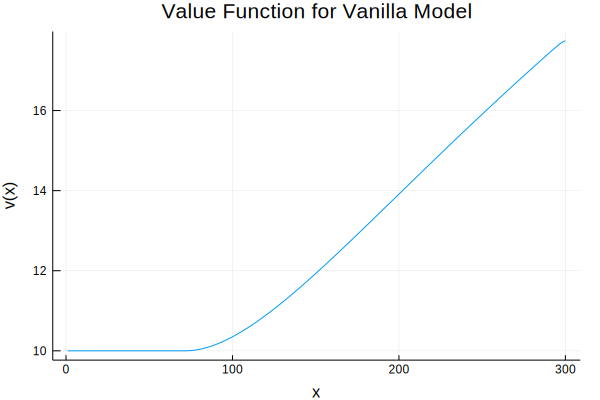

In [8]:
using Plots
v = sol_z + S 
plot(v, title = "Value Function for Vanilla Model", legend = false, xlabel = "x", ylabel = "v(x)")

This is the kind of thing we expect --- below some threshold you get the stopping value $S \equiv 10$, and above it you get a smoothly increasing value.

**Note:** `PATHSolver.jl` is the backend used by `Complementarity.jl`, so there's no need to test that package separately (and, in fact, I couldn't get the macro/JuMP setup to work.)

### Approach 2: Same Problem with NLsolve

In [9]:
using NLsolve

In [10]:
function f!(F, z)
    F .= B*z + q # in place assignment
end

f! (generic function with 1 method)

In [11]:
@time r = mcpsolve(f!, lb, ub,
                zeros(n), # initial condition
                reformulation = :smooth, # uses a so-called "Fischer function" to smooth out the problem
                autodiff = :forward,
                ftol = 1e-4)

  4.113968 seconds (12.62 M allocations: 645.335 MiB, 8.75% gc time)


Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

As before, we can plot the resulting value function.

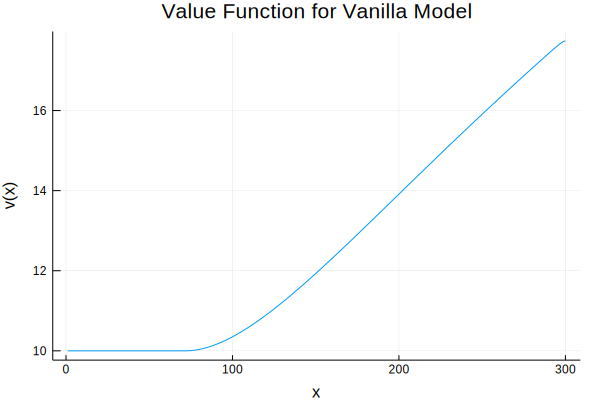

In [12]:
v = r.zero + S 
plot(v, title = "Value Function for Vanilla Model", legend = false, xlabel = "x", ylabel = "v(x)")

Reassuringly, they look about the same.

### Approach 3: Same Problem in VariationalInequality.jl 

In [13]:
using VariationalInequality, JuMP

As you can see, each element of the value function is treated as a separate variable.

In [62]:
m = VIPModel() # The model is certainly very important, but is also a Variational Inequality Problem
@variable(m, z[i = 1:n] >= 0)

300-element Array{Variable,1}:
 z[1]  
 z[2]  
 z[3]  
 z[4]  
 z[5]  
 z[6]  
 z[7]  
 z[8]  
 z[9]  
 z[10] 
 z[11] 
 z[12] 
 z[13] 
 ⋮     
 z[289]
 z[290]
 z[291]
 z[292]
 z[293]
 z[294]
 z[295]
 z[296]
 z[297]
 z[298]
 z[299]
 z[300]

In [63]:
@mapping(m, F[i = 1:n], B[i, :]*z);
@innerproduct(m, F, z);

In [64]:
@time sol1, sol_z, slack = solveVIP(m, algorithm=:fixed_point, max_iter=50, step_size=0.1, tolerance=1e-4)

iteration    1: rel_err= 0.470608773945
iteration    2: rel_err= 0.467438576840
iteration    3: rel_err= 0.464291556248
iteration    4: rel_err= 0.461165159352
iteration    5: rel_err= 0.458059721884
iteration    6: rel_err= 0.454974206216
iteration    7: rel_err= 0.451909015145
iteration    8: rel_err= 0.448863390588
iteration    9: rel_err= 0.445837717900
iteration   10: rel_err= 0.442831242269
iteration   11: rel_err= 0.439844556278
iteration   12: rel_err= 0.436876620644
iteration   13: rel_err= 0.433928366832
iteration   14: rel_err= 0.430998360484
iteration   15: rel_err= 0.428088220557
iteration   16: rel_err= 0.425195854539
iteration   17: rel_err= 0.422324027148
iteration   18: rel_err= 0.419469815141
iteration   19: rel_err= 0.416638359639
iteration   20: rel_err= 0.413826221701
iteration   21: rel_err= 0.411044377554
iteration   22: rel_err= 0.408292084460
iteration   23: rel_err= 0.405597586213
iteration   24: rel_err= 0.402979242187
iteration   25: rel_err= 0.400524206095


┌ Warning: Not solved to optimality, status: Unbounded
└ @ JuMP /home/arnavsood/.julia/packages/JuMP/PbnIJ/src/nlp.jl:1283


(Dict(z[211]=>1.4435,z[21]=>4.59556e-8,z[33]=>6.85643e-8,z[85]=>0.0,z[248]=>1.75896,z[132]=>0.6561,z[249]=>1.76714,z[49]=>1.30798e-7,z[130]=>0.633337,z[263]=>1.87992…), Dict(z[211]=>-0.240665,z[21]=>0.223919,z[33]=>0.159481,z[85]=>-30.9266,z[248]=>-0.297072,z[132]=>-0.098827,z[249]=>-0.298532,z[49]=>0.0889894,z[130]=>-0.0946951,z[263]=>-0.318659…), 2.0400289176050395)